In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
from math import floor
from timeit import default_timer as timer

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/leowyaoyang/fyp-graph-clustering'

## Prepare ImageNet data

In [5]:
parent_dir = os.path.abspath('..')
data_dir = parent_dir + '/data/imagenet'

In [6]:
batch_size = 10
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
train_class_names = image_datasets['train'].classes
test_class_names = image_datasets['val'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [7]:
dataset_sizes

{'train': 3350, 'val': 422}

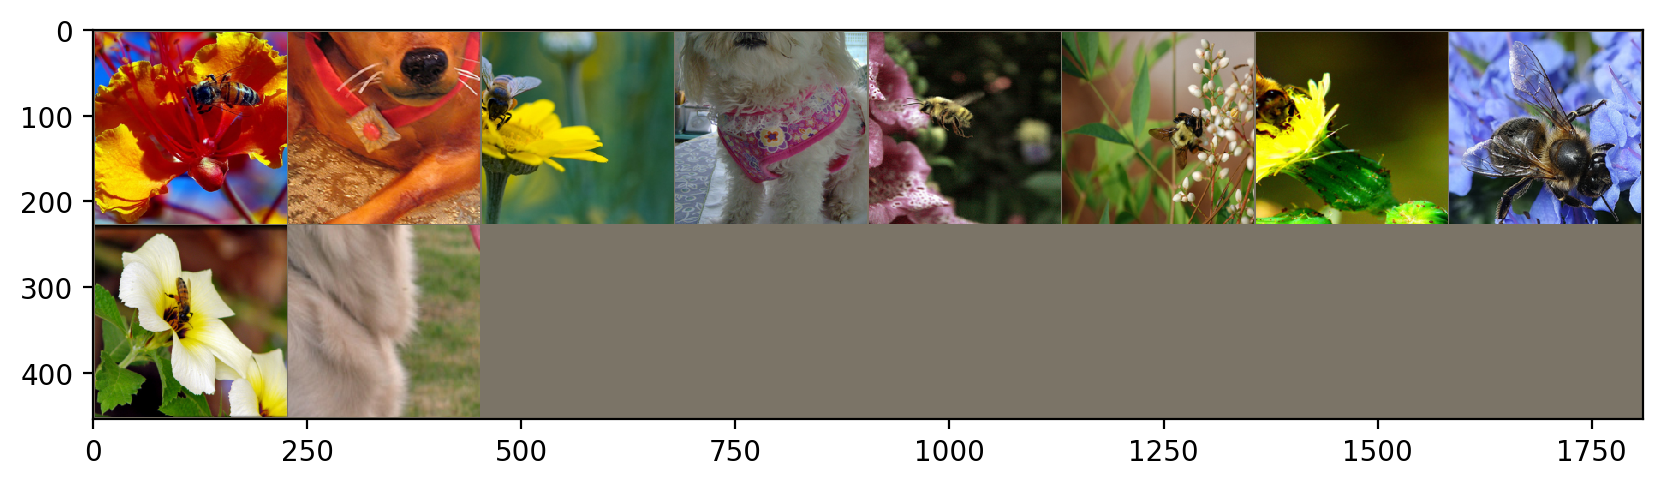

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    f, ax = plt.subplots(1, 1, figsize=(10,20), dpi=200)
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)
#imshow(out, title=[train_class_names[x] for x in classes])

In [9]:
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

In [10]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
# # Get next to last outputs
# class MyModel(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyModel, self).__init__()
#         image_modules = list(pretrained_model.children())[:-1] #all layer expect last layer
#         self.modelA = nn.Sequential(*image_modules)
        
#     def forward(self, image):
#         out = self.modelA(image)
#         return out

In [ ]:
# feature_model = MyModel(model)
# feature_model = feature_model.to(device)

## Obtain feature vectors for train set

In [11]:
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

In [12]:
# Define a function that will copy the output of a layer
my_embedding = torch.zeros([batch_size, 512, 1, 1]) 

def copy_data(m, i, o):
    my_embedding.copy_(o.data)
    
# Attach that function to our selected layer
h = layer.register_forward_hook(copy_data)

In [14]:
max_batches = floor(len(image_datasets['train'])/batch_size)
n_samples = max_batches * batch_size
#n_samples = len(image_datasets['train'])
outputs = torch.zeros([n_samples, 512, 1, 1])
output_labels = torch.zeros([n_samples])
i = 0
for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
    if batch_idx == max_batches: break
    inputs = inputs.to(device)
    labels = labels.to(device)
    model(inputs)
    
    outputs[i:i+batch_size] = my_embedding
    output_labels[i:i+batch_size] = labels
    i += batch_size

In [15]:
outputs.shape

torch.Size([3350, 512, 1, 1])

In [16]:
from core.DimReduction import DimReduction
X = outputs.detach().numpy()
X = X.reshape(-1,512)

dim_red = DimReduction(n_components=30)
X_pca = dim_red.fit_transform(X, 'pca')

In [17]:
from sklearn import manifold
perplexity = 30.0
embedder = manifold.TSNE(n_components=2, perplexity=perplexity, init='pca', n_iter=2000, random_state=0, verbose=1)
X_emb = embedder.fit_transform(X_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3350 samples in 0.004s...
[t-SNE] Computed neighbors for 3350 samples in 0.666s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3350
[t-SNE] Computed conditional probabilities for sample 2000 / 3350
[t-SNE] Computed conditional probabilities for sample 3000 / 3350
[t-SNE] Computed conditional probabilities for sample 3350 / 3350
[t-SNE] Mean sigma: 3.748423
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.577522
[t-SNE] Error after 2000 iterations: 1.810724


In [23]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [24]:
from util.plot_bokeh_embedding import plot_embedding

In [22]:
int_labels = [int(l) for l in output_labels]
named_labels = [train_class_names[i] for i in int_labels]
plot_embedding(X_emb, int_labels, named_labels)

In [24]:
# Save data
import pickle
print(X.shape)
print(len(int_labels))
print(X_emb.shape)
with open('imagenet_2_train.pkl', 'wb') as f:
    pickle.dump([X, int_labels, X_emb], f)

(3350, 512)
3350
(3350, 2)


In [25]:
# Using PCA
dim_red = DimReduction(n_components=2)
X_pca = dim_red.fit_transform(X, 'pca')

In [26]:
named_labels = [train_class_names[i] for i in int_labels]
plot_embedding(X_pca, int_labels, named_labels)

## Test set

In [13]:
max_batches = floor(len(image_datasets['val'])/batch_size)
n_samples = max_batches * batch_size
#n_samples = len(image_datasets['train'])
outputs = torch.zeros([n_samples, 512, 1, 1])
output_labels = torch.zeros([n_samples])
i = 0
for batch_idx, (inputs, labels) in enumerate(dataloaders['val']):
    if batch_idx == max_batches: break
    inputs = inputs.to(device)
    labels = labels.to(device)
    model(inputs)
    
    outputs[i:i+batch_size] = my_embedding
    output_labels[i:i+batch_size] = labels
    i += batch_size

In [14]:
outputs.shape

torch.Size([420, 512, 1, 1])

In [15]:
X_test = outputs.detach().numpy()
X_test = X_test.reshape(-1,512)

In [50]:
start = timer()

dim_red = DimReduction(n_components=30)
X_test_pca = dim_red.fit_transform(X_test, 'pca')

perplexity = 30.0
embedder = manifold.TSNE(n_components=2, perplexity=perplexity, init='pca', n_iter=2000, random_state=0, verbose=1)
X_test_emb = embedder.fit_transform(X_test_pca)

print("Time to compute = {}".format(timer()-start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 420 samples in 0.001s...
[t-SNE] Computed neighbors for 420 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 420 / 420
[t-SNE] Mean sigma: 4.603266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.405159
[t-SNE] Error after 1700 iterations: 0.941213
Time to compute = 10.880896405000385


In [32]:
int_labels_test = [int(l) for l in output_labels]
named_labels_test = [test_class_names[i] for i in int_labels_test]
plot_embedding(X_test_emb, int_labels_test, named_labels_test)

In [51]:
start = timer()

dim_red = DimReduction(n_components=2)
X_test_pca = dim_red.fit_transform(X_test, 'pca')

print("Time to compute = {}".format(timer()-start))

Time to compute = 0.0069286980005927035


In [34]:
plot_embedding(X_test_pca, int_labels_test, named_labels_test)

## Graph net on test set

In [16]:
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph

In [29]:
from core.SimpleNet import SimpleNet

In [17]:
G = DataEmbeddingGraph(X_test, [])

In [30]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = 512 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers

# Graph net
#net = GraphConvNet2(net_parameters)
net = SimpleNet(net_parameters)
if torch.cuda.is_available(): net.cuda()
root = 'results/imagenet_2/'
filename = root + 'simple_net_2000.pkl'
checkpoint = torch.load(filename, map_location=device)
net.load_state_dict(checkpoint['state_dict'])

In [31]:
# Net
start = timer()

if torch.cuda.is_available():   
    y_pred = net.forward(G).cpu().detach().numpy()
else:    
    y_pred = net.forward(G).detach().numpy()
    
print("Time to compute = {}".format(timer()-start))

Time to compute = 0.0034957109996867075


In [32]:
int_labels_test = [int(l) for l in output_labels]
named_labels_test = [test_class_names[i] for i in int_labels_test]
plot_embedding(y_pred, int_labels_test, named_labels_test)

In [33]:
from util.evaluation_metrics import nearest_neighbours_generalisation_accuracy
from sklearn.manifold.t_sne import trustworthiness

In [34]:
X_to_compare = y_pred
labels_to_compare = np.array(int_labels_test)
one_nn = nearest_neighbours_generalisation_accuracy(X_to_compare, labels_to_compare, n_neighbors=1)
five_nn = nearest_neighbours_generalisation_accuracy(X_to_compare, labels_to_compare, n_neighbors=5)
trust = trustworthiness(X_test, X_to_compare, n_neighbors=12)
print(one_nn)
print(five_nn)
print(trust)

0.8952380952380953
0.9285714285714286
0.8455761133843326
